Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Past Methods for Time Series Forecasting - (S)ARIMA

* Python ARIMA: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
* Python SARIMA: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
* Python Auto ARIMA: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import itertools
import pmdarima as pm
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [23]:
ts_df = pd.read_pickle('../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df_train = ts_df.iloc[ts_df.index < '2015-03-01']
ts_df_test = ts_df.iloc[ts_df.index >= '2015-03-01']
print(ts_df_train.shape, ts_df_test.shape)

ts_df_train.head()

(942, 1)
(789, 1) (153, 1)


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


## ACF & PACF Plot

* The time series used for the plot should be stationary

In [48]:
# Function to plot the original ts, ACF and PACF
def plotds(ts, title, nlag=30, fig_size=(12, 10)):
    """
    Draw the ACF, PACF plots of the time series.
    
    @param ts: the input time series data
    @param title: the title of the figure
    @param nlag: the number of lags shown in the plots
    @param fig_size: the figure size in (width, height)
    @return: None
    """
    if not isinstance(ts, pd.Series):
         ts = pd.Series(ts)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_ts = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    ts.plot(ax=ax_ts)
    ax_ts.set_title(f'ACF & PACF of {title}')
    plot_acf(ts, lags=nlag, ax=ax_acf)
    plot_pacf(ts, lags=nlag, ax=ax_pacf)
    plt.tight_layout()

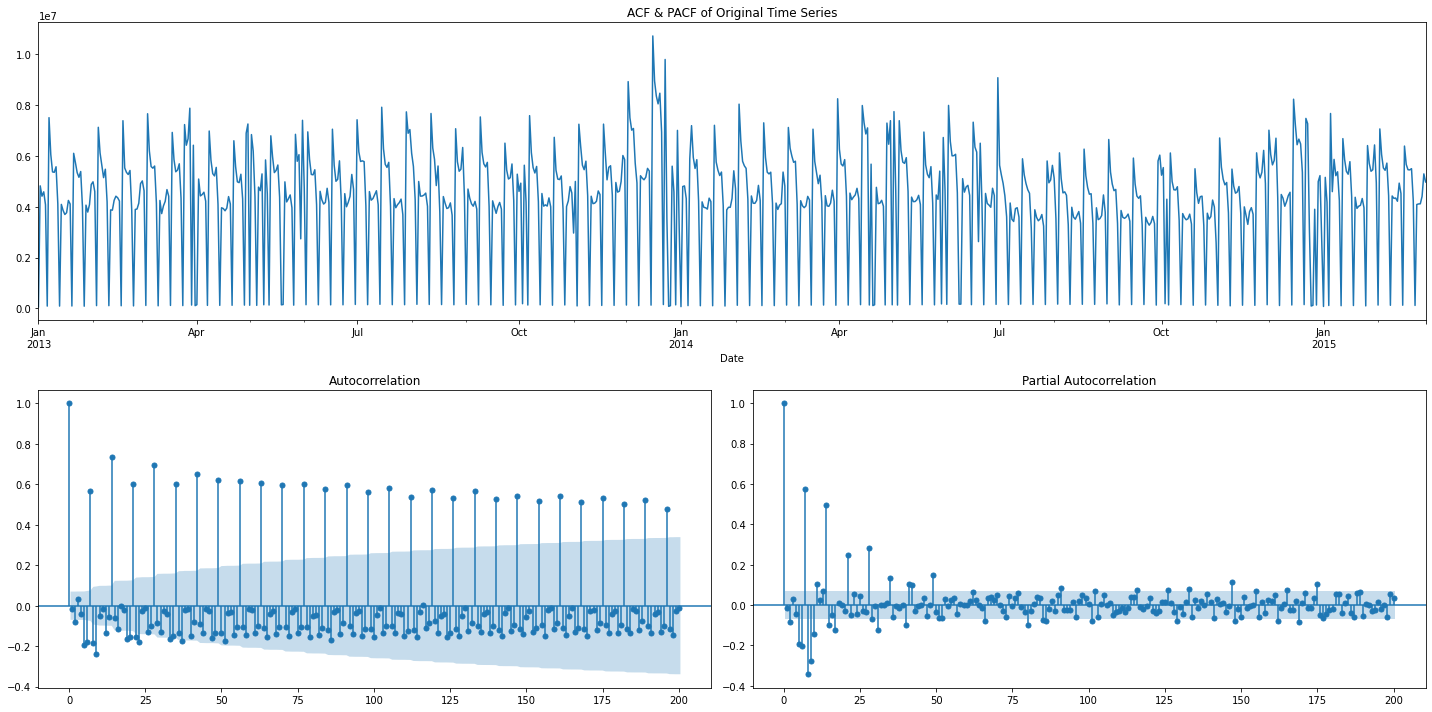

In [49]:
plotds(ts_df_train['Daily_Sales'], title='Original Time Series', nlag=200, fig_size=(20, 10))

## Forecasting

* How to interpret `summary()` and `plot_diagnostics()`: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
  * Summary results:
    * Check AIC, BIC as model performance on training data, larger value worse performance
    * The absolute value of the `coef` indicates the importance of each feature, `P>|z|` can prove further, as when p-value is lower than the significant level (such as 0.05) the feature is important
   * Diagnostics plot:
     * Check residual to see whether it's random enough
     * Both Q-Q plot and Histogram & KDE plot are checking whether the residual is normally distributed
     * Correlogram is to confirm whether there is seasonality left by checking whether the residuals have autocorrelation with its lagged data
     
### Forecast with Manually Assigned ARIMA

In [50]:
def ariam_fit(train_ts, **args):
    """
    Fit ARIMA model.
    
    @param train_ts: the training time series data
    @param **args: a dictionary of ARIMA params' (key, value) pairs
    @return: the fitted ARIMA model
    """
    ts = timeit.default_timer()
    arima_obj = ARIMA(train_ts, **args)
    arima_obj_fit = arima_obj.fit()
    te = timeit.default_timer()
    print(f'Execution Time: {te - ts} seconds')
    print(arima_obj_fit.summary())
    fig = arima_obj_fit.plot_diagnostics(figsize=(15, 12))
    
    return arima_obj_fit


def sariam_fit(train_ts, **args):
    """
    Fit SARIMA model.
    
    @param train_ts: the training time series data
    @param **args: a dictionary of SARIMA params' (key, value) pairs
    @return: the fitted SARIMA model
    """
    ts = timeit.default_timer()
    sarima_obj = SARIMAX(train_ts, **args)
    sarima_obj_fit = sarima_obj.fit()
    te = timeit.default_timer()
    print(f'Execution Time: {te - ts} seconds')
    print(sarima_obj_fit.summary())
    fig = sarima_obj_fit.plot_diagnostics(figsize=(15, 12))
    
    return sarima_obj_fit
    
    
def arima_forecast(train_ts, test_ts, fitted_model, title):
    """
    Forecast and plot the train, test & forecasted time series.
    
    @param train_ts: the training time series data
    @param test_ts: the testing time series data
    @param fitted_model: the trained model
    @param title: the title of the plot
    @return: return the forecast performance results
    """
    y_pred = fitted_model.forecast(len(test_ts))
    
    pred_mape = mape(test_ts, y_pred)
    pred_r2 = r2_score(test_ts, y_pred)
    
    plt.figure(figsize=(20,7))
    plt.plot(train_ts.index, train_ts, label='Train')
    plt.plot(test_ts.index, test_ts, label='Test')
    plt.plot(test_ts.index, y_pred, label='Forecast')
    plt.legend(loc='best')
    plt.title(f'{title} (MAPE: {pred_mape}, R2: {pred_r2})')
    plt.show()
    
    return pred_mape, pred_r2

Execution Time: 1.4228297000008752 seconds
                               SARIMAX Results                                
Dep. Variable:            Daily_Sales   No. Observations:                  789
Model:                ARIMA(10, 0, 0)   Log Likelihood              -12330.890
Date:                Sun, 17 Jul 2022   AIC                          24685.780
Time:                        20:30:39   BIC                          24741.829
Sample:                    01-01-2013   HQIC                         24707.325
                         - 02-28-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.212e+06   4.72e+04     89.274      0.000    4.12e+06     4.3e+06
ar.L1          0.1147      0.028      4.172      0.000       0.061       0.169
ar.L2    

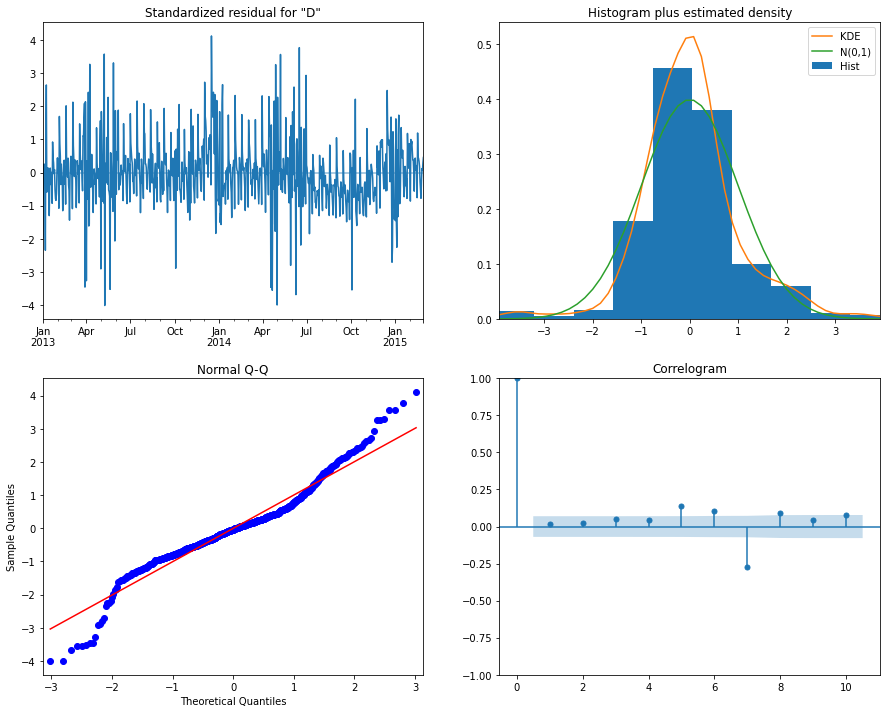

In [51]:
arima_args = {'freq': 'D', 'order': (10, 0, 0)}
arima_fitted = ariam_fit(ts_df_train, **arima_args)

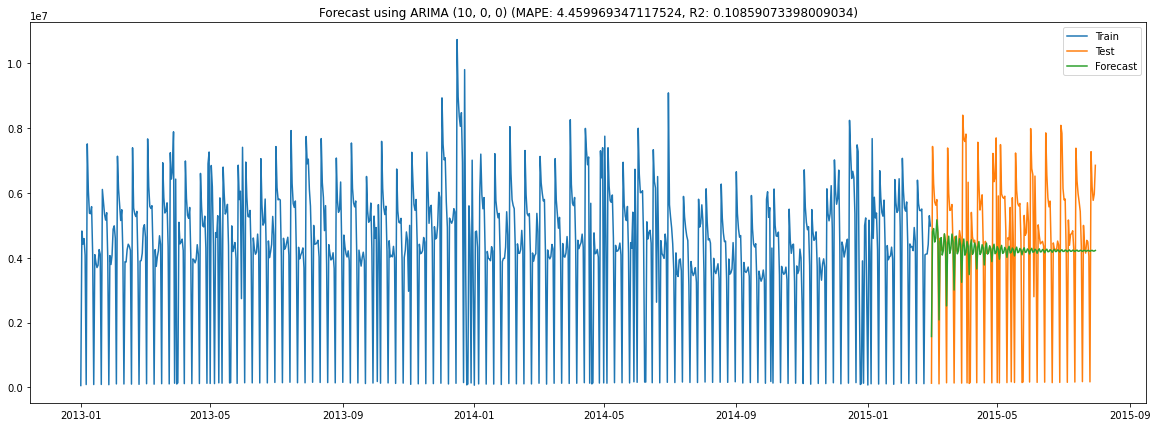

In [52]:
pred_mape_arima, pred_r2_arima = arima_forecast(ts_df_train, ts_df_test, arima_fitted, title=f"Forecast using ARIMA {arima_args['order']}")

### Forecast with Manually Assigned SARIMA

Execution Time: 45.68005940000148 seconds
                                     SARIMAX Results                                      
Dep. Variable:                        Daily_Sales   No. Observations:                  789
Model:             SARIMAX(1, 0, 0)x(10, 0, 0, 7)   Log Likelihood              -12531.283
Date:                            Sun, 17 Jul 2022   AIC                          25086.567
Time:                                    20:31:31   BIC                          25142.616
Sample:                                01-01-2013   HQIC                         25108.113
                                     - 02-28-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3013      0.116      2.589      0.010       0.073      

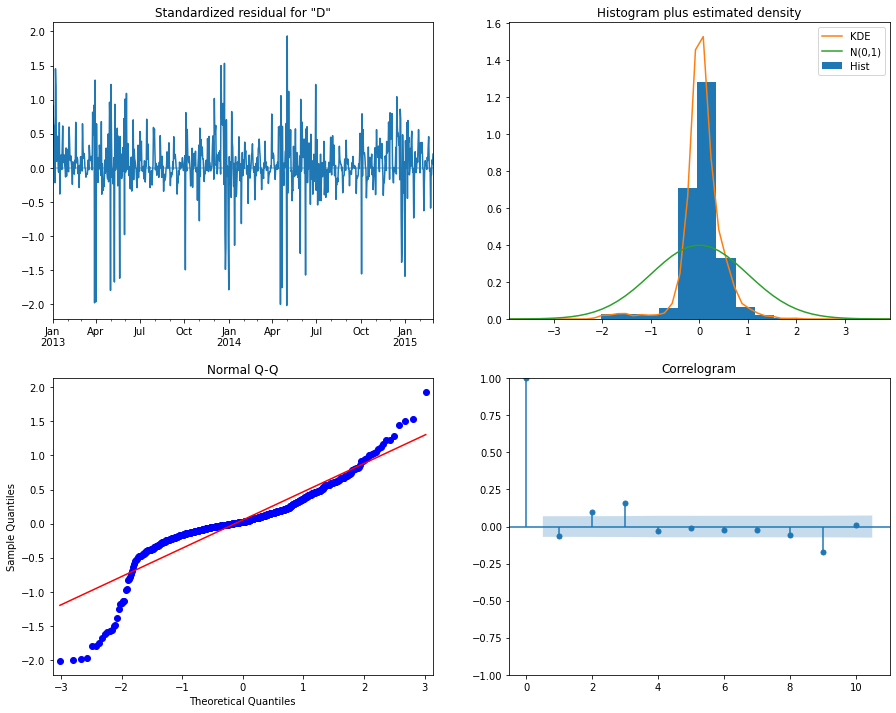

In [53]:
sarima_args = {'seasonal_order': (10, 0, 0, 7)}
sarima_fitted = sariam_fit(ts_df_train, **sarima_args)

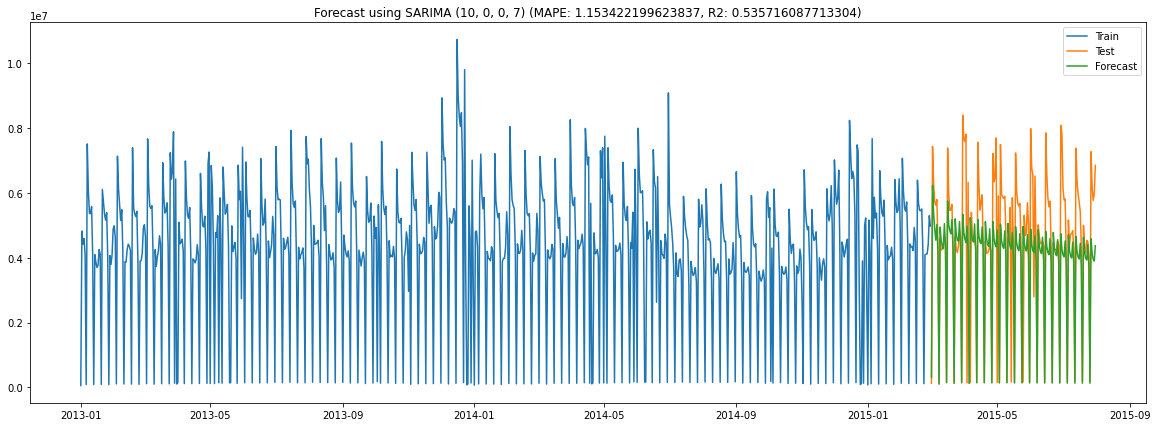

In [54]:
pred_mape_sarima, pred_r2_sarima = arima_forecast(ts_df_train, ts_df_test, sarima_fitted, title=f"Forecast using SARIMA {sarima_args['seasonal_order']}")

### Forecast with SARIMA & Param Tuning

* Param Tuning uses adjustable rolling window to find the most frequent best param set as the selected params

In [30]:
def sarima_adjustable_grid_search(train, valid, grid_params):
    """
    Find params that can improve the best performance of (train, valid) pairs, otherwise return None.

    @param train: the training data
    @param valid: the validation data
    @param grid_params: a list of all the params choices
    @return: the params that can further improvement the performance, otherwise return None
    """
    best_params = None
    best_mape = np.inf
    
    for params in grid_params: 
        model_fit = SARIMAX(train, seasonal_order=(params)).fit()
        y_pred = model_fit.forecast(len(valid))
            
        sub_mape = mape(valid, y_pred)
        if sub_mape < best_mape:
            best_params = params
            best_mape = sub_mape
            
    return best_params, best_mape

In [40]:
ts_df_train_hpo = ts_df.iloc[ts_df.index < '2014-03-01']
ts_df_val_hpo = ts_df.iloc[(ts_df.index >= '2014-03-01') & (ts_df.index < '2015-03-01')]
ts_df_test = ts_df.iloc[ts_df.index >= '2015-03-01']

print(ts_df_train_hpo.shape, ts_df_val_hpo.shape, ts_df_test_hpo.shape)
print(min(ts_df_train_hpo.index), max(ts_df_train_hpo.index))
print(min(ts_df_val_hpo.index), max(ts_df_val_hpo.index))
print(min(ts_df_test.index), max(ts_df_test.index))

ts_df_train_hpo.head()

(424, 1) (365, 1) (212, 1)
2013-01-01 00:00:00 2014-02-28 00:00:00
2014-03-01 00:00:00 2015-02-28 00:00:00
2015-03-01 00:00:00 2015-07-31 00:00:00


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


In [41]:
params_dct = {
    'p': [7, 10, 14],  # make sure this value is no longer than the training data used in the model
    'd': [0],
    'q': [0],
    'season_order': [7, 9]
}
default_params = (10, 0, 0, 7)

grid_params = list(itertools.product(params_dct['p'], params_dct['d'], params_dct['q'], params_dct['season_order']))
grid_params

[(7, 0, 0, 7),
 (7, 0, 0, 9),
 (10, 0, 0, 7),
 (10, 0, 0, 9),
 (14, 0, 0, 7),
 (14, 0, 0, 9)]

In [42]:
best_params, best_mape = sarima_adjustable_grid_search(ts_df_train_hpo, ts_df_val_hpo, grid_params)
print(best_params, best_mape)

(7, 0, 0, 7) 0.9616409634624392


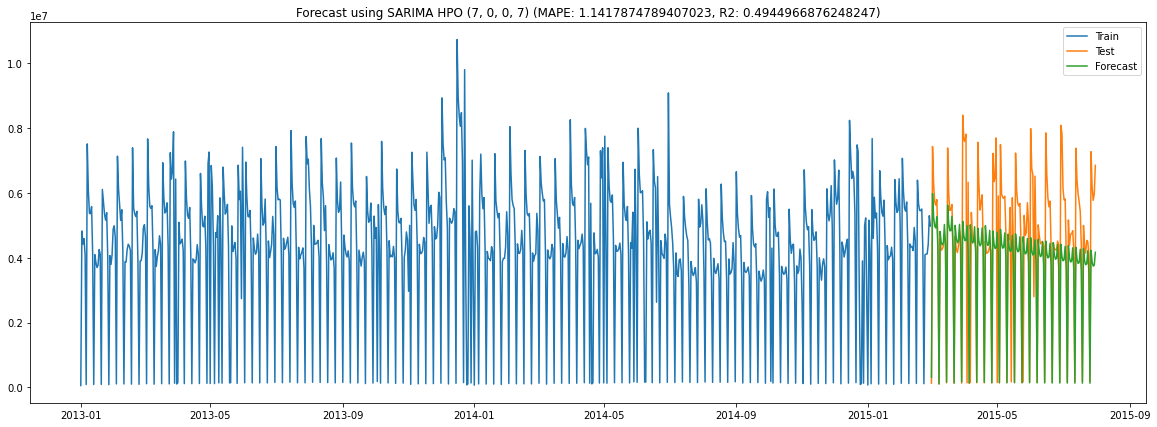

In [43]:
sarima_hpo_fitted = SARIMAX(ts_df_train, seasonal_order=best_params).fit()
pred_mape_sarima_hpo, pred_r2_sarima_hpo = arima_forecast(ts_df_train, ts_df_test, sarima_hpo_fitted, title=f"Forecast using SARIMA HPO {best_params}")

## Summary

In [55]:
summarized_performance = {}
summarized_performance[0] = {'Experiment': 'Manually ARIMA', 'MAPE': pred_mape_arima, 'R2': pred_r2_arima}
summarized_performance[1] = {'Experiment': 'Manually SARIMA', 'MAPE': pred_mape_sarima, 'R2': pred_r2_sarima}
summarized_performance[2] = {'Experiment': 'HPO SARIMA', 'MAPE': pred_mape_sarima_hpo, 'R2': pred_r2_sarima_hpo}

summarized_performance_df = pd.DataFrame(summarized_performance).T
summarized_performance_df = summarized_performance_df.sort_values(by='MAPE')
summarized_performance_df

,Experiment,MAPE,R2
2,HPO SARIMA,1.141787,0.494497
1,Manually SARIMA,1.153422,0.535716
0,Manually ARIMA,4.459969,0.108591
